## Telecom User Data Analysis

### Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from statistics import mean
from pandas_profiling import ProfileReport
import numpy as np
import json
import datetime
import math

from datetime import timedelta, datetime

import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

import seaborn as sns


### Data Preprocessing

In [2]:
df = pd.read_csv("../data/telcom.csv")

In [118]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,2019-04-04 12:01:18,770.0,2019-04-25 14:35:31,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9164566995485190,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,2019-04-09 13:04:04,235.0,2019-04-25 08:15:48,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,2019-04-09 17:42:11,1.0,2019-04-25 11:58:13,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,2019-04-10 00:31:25,486.0,2019-04-25 07:36:35,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,2019-04-12 20:10:23,565.0,2019-04-25 10:40:32,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [6]:
### Check for sufficiency of data to answer objectives by reviewing the objective and 
### available data. And check the number of observations and required sample size.

In [120]:
df.shape

(150001, 55)

In [3]:
### we can begin by generating pipelines

In [7]:
np.zeros(1)

array([0.])

In [22]:
# generate pipelines
def generate_pipeline(type_="numeric",x=1):
    pipeline = None
    if type_ == "numeric":
        pipeline = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='mean')),
            ('scale', MinMaxScaler())
        ])
    elif type_ == "categorical":
        pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])
    else:
        pipeline = np.zeros(x)
    return pipeline



In [23]:
# test pipeline
numeric_pipeline = generate_pipeline("numeric")
assert isinstance(numeric_pipeline,Pipeline)

In [24]:
categorical_pipeline = generate_pipeline("categorical")
assert isinstance(numeric_pipeline,Pipeline)

In [35]:
def store_features(df,type_,value):
    features = [None]
    if type_ == "numeric":
        features = df.select_dtypes(include=value).columns.tolist()
    elif type_ == "categorical":
        features = df.select_dtypes(exclude=value).columns.tolist()
    return features


In [36]:
# testing function
numerical_features = store_features(df,"numeric","number")

In [39]:
assert len(numerical_features)>0

In [10]:
### checking for duplicates

In [27]:
def generate_transformation(pipeline,df,type_,value):
    transformation = None
    if type_=="numeric":
        transformation=pipeline.fit_transform(df.select_dtypes(include=value))
    elif type_ == "categorical":
        transformation=pipeline.fit_transform(df.select_dtypes(exclude=value))
    return transformation

In [140]:
# test transformations
numeric_transformation = generate_transformation(numeric_pipeline,df,"numeric","number")

In [137]:
def frame_transforms(transform,features):
    return pd.DataFrame(transform,columns=features)

In [152]:
numeric_df = frame_transforms(numeric_transformation,numerical_features)

In [46]:
def split_data(df,response_variable,split_ratio,get):
    X = df.drop(response_variable, axis=1)
    y = df[response_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, 
                                                    random_state=1121218)
    if get == "X_train":
        return X_train
    elif get == "X_test":
        return X_test
    elif get == "y_train":
        return y_train
    else:
        return y_test
    
    

In [51]:
numeric_transformation = generate_transformation(numeric_pipeline,
                                                 pd.DataFrame(split_data(df,"Total DL (Bytes)",0.3,"X-train")),
                                                 "numeric","number")

In [13]:
### Check for column organization and naming and correct them.

In [59]:
### Check for missing values and either fill them with a value that will, in no way, 
### affect the analysis or remove the record.

In [21]:
def handle_missing_values(df,x):
    """
    this algorithm does the following
    - remove columns with x percentage of missing values
    - fill the missing values with the mean
    returns:
        - df
        - percentage of missing values
    """
    missing_percentage = round((df.isnull().sum().sum()/\
            reduce(lambda x, y: x*y, df.shape))*100,2)
    null_cols = df.isnull().sum().to_dict()
    for key,val in null_cols.items():
        if val/df.shape[0] > x:
            df.drop([key], axis=1)
        elif  val/df.shape[0] < x and val > 0 and df[key].dtype.kind in 'biufc':
            df.fillna(df[key].mean().round(1), inplace=True)
    return missing_percentage, df

In [26]:
# test the function
missing_percentage,df = handle_missing_values(df,x=0.3)
True in df.isna().any().to_list()

False

In [105]:
def top_x_column(df, x, column,color,online=False):
    handsets_df = pd.DataFrame(columns = [column])
    handsets_df['type'] = df[column].to_list()
    handsets = handsets_df['type'].value_counts()
    fig,ax = plt.subplots()
    ax.tick_params(axis='x',labelsize=10)
    ax.tick_params(axis='y',labelsize=10)
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")
    ax.set_title(f"The {x} Most Frequent {column}")
    handsets[:x].plot(ax=ax,kind='bar',color=color)
    handset_counts = handsets.to_dict()
    top_x = list(handset_counts.keys())
    if online:
        return fig,top_x[:x]
    else:
        return top_x[:x]
    

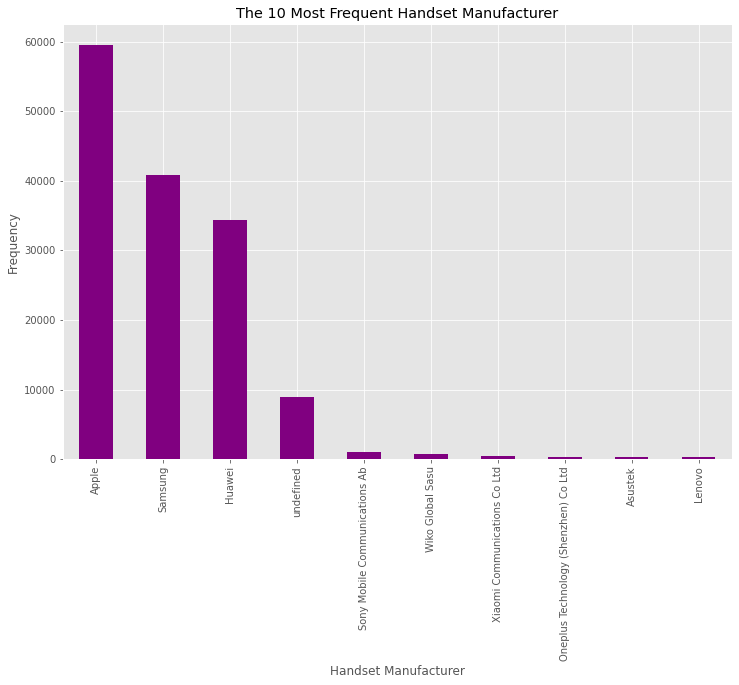

In [106]:
# identifying the top 10 handsets used by the customers.
values = top_x_column(df,10,"Handset Manufacturer","purple")

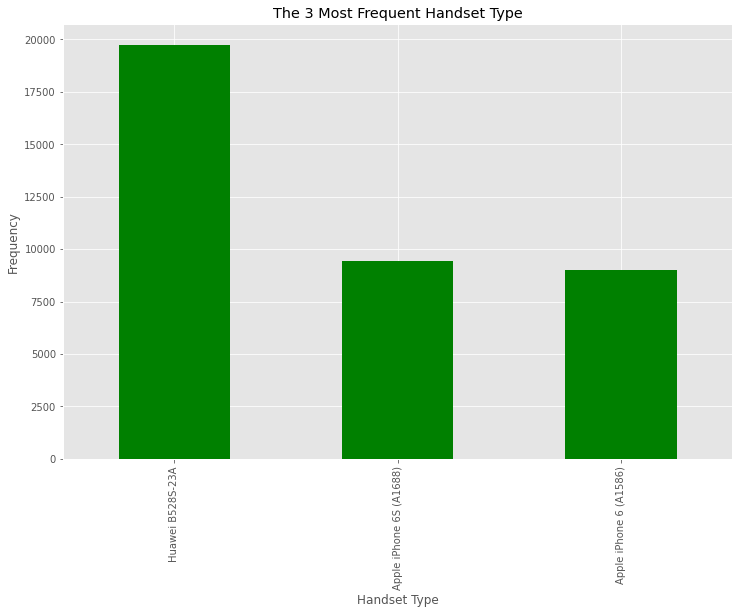

In [111]:
values = top_x_column(df,3,"Handset Type","green")

In [112]:
values

['Huawei B528S-23A', 'Apple iPhone 6S (A1688)', 'Apple iPhone 6 (A1586)']

In [121]:
# Identify the top 5 handsets per top 3 handset manufacturer
def top_x_by_y_cols(df,col_1,col_2,x,y):
    result_df = []
    by_manufacture = df.groupby(col_1,sort=True)
    values = top_x_column(df,x,col_1,"purple")


    for manufacturer, frame in by_manufacture:
        if manufacturer in values:
            result_df.append(frame.sort_values(by=[col_2], ascending=True)[col_2].head(5))
    return result_df
    

[50178     Apple iPad (A1823)
 50098     Apple iPad (A1823)
 40765     Apple iPad (A1823)
 57874     Apple iPad (A1823)
 114763    Apple iPad (A1823)
 Name: Handset Type, dtype: object,
 77840        Huawei Ale-Ul00
 17997        Huawei Ale-Ul00
 99869       Huawei Ascend G6
 99247       Huawei Ascend G6
 5655     Huawei Ascend G620S
 Name: Handset Type, dtype: object,
 10522    Samsung 2018 Galaxy J4
 91735    Samsung 2018 Galaxy J4
 95269    Samsung 2018 Galaxy J4
 80690    Samsung 2018 Galaxy J4
 10574    Samsung 2018 Galaxy J4
 Name: Handset Type, dtype: object]

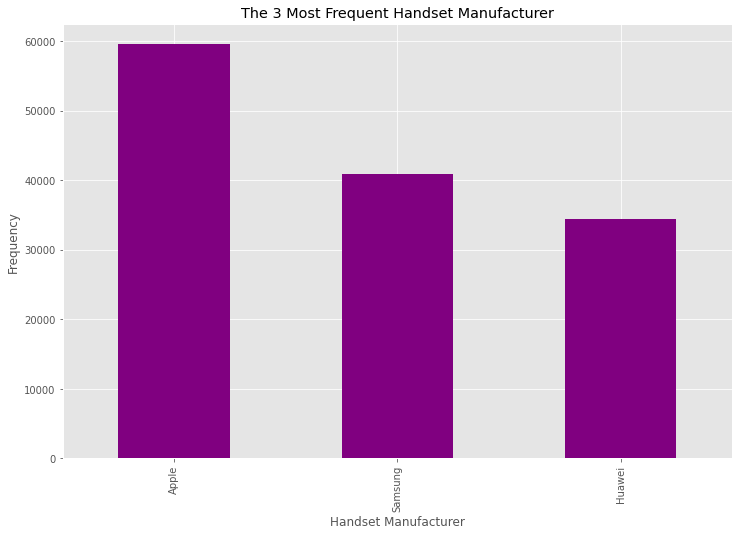

In [122]:
top_x_by_y_cols(df,'Handset Manufacturer','Handset Type',3,5)

In [127]:
# Aggregation per user the following information in the column  
# number of xDR sessions
# Session duration
# the total download (DL) and upload (UL) data
# the total data volume (in Bytes) during this session for each application


def aggregation_cols(df,col_1,col_2,trim=False):
    
    grouped = df.groupby(col_1).agg({col_2: [min, max, mean]}) 
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    if trim:
        return grouped.describe()
    return grouped

In [129]:
aggregation_cols(df,'MSISDN/Number','Bearer Id',True)

,Bearer Id_min,Bearer Id_max,Bearer Id_mean
count,1.064710e+05,1.064710e+05,1.064280e+05
mean,9.861108e+18,9.884478e+18,9.872591e+18
std,2.880065e+18,2.882506e+18,2.878324e+18
min,6.917540e+18,6.917540e+18,6.917540e+18
25%,7.277830e+18,7.349880e+18,7.313855e+18
50%,7.349880e+18,7.349880e+18,7.349880e+18
75%,1.304240e+19,1.311450e+19,1.307845e+19
max,1.318650e+19,1.318650e+19,1.318650e+19


In [130]:
aggregation_cols(df,'MSISDN/Number',"Dur. (ms)",True)

,Dur. (ms)_min,Dur. (ms)_max,Dur. (ms)_mean
count,1.068560e+05,1.068560e+05,1.068560e+05
mean,9.670630e+04,1.092361e+05,1.026948e+05
std,6.860320e+04,8.302563e+04,7.224737e+04
min,7.142000e+03,7.142000e+03,7.142000e+03
25%,5.095100e+04,5.795325e+04,5.640975e+04
50%,8.639900e+04,8.640100e+04,8.640000e+04
75%,1.253688e+05,1.432058e+05,1.339121e+05
max,1.573420e+06,1.859336e+06,1.573420e+06


In [131]:
aggregation_cols(df,'MSISDN/Number','Total UL (Bytes)',True)

,Total UL (Bytes)_min,Total UL (Bytes)_max,Total UL (Bytes)_mean
count,1.068560e+05,1.068560e+05,1.068560e+05
mean,3.906698e+07,4.318572e+07,4.112710e+07
std,1.126727e+07,1.126055e+07,1.038667e+07
min,2.866892e+06,2.866892e+06,2.866892e+06
25%,3.105607e+07,3.544135e+07,3.419706e+07
50%,3.878098e+07,4.351793e+07,4.112701e+07
75%,4.684226e+07,5.121987e+07,4.808021e+07
max,7.833131e+07,7.833131e+07,7.833131e+07


In [132]:
aggregation_cols(df,'MSISDN/Number','Total DL (Bytes)',True)

,Total DL (Bytes)_min,Total DL (Bytes)_max,Total DL (Bytes)_mean
count,1.068560e+05,1.068560e+05,1.068560e+05
mean,4.101001e+08,5.003891e+08,4.551845e+08
std,2.429118e+08,2.424849e+08,2.247906e+08
min,7.114041e+06,8.827082e+06,8.827082e+06
25%,1.956287e+08,2.990552e+08,2.762649e+08
50%,3.891675e+08,5.228647e+08,4.562455e+08
75%,6.119677e+08,7.137592e+08,6.338121e+08
max,9.029696e+08,9.029696e+08,9.029696e+08


## EDA Analysis

In [243]:
#Describe all  relevant variables and associated data types
# Analyze the basic metrics (mean, median, etc) in the Dataset (explain) & 
# their importance for the global objective.
# Conduct a Non-Graphical Univariate Analysis by computing dispersion parameters 
# for each quantitative variable and provide useful interpretation.

def non_graphical_analysis(df,features,type_,x=1):
    result = None
    if type_ == "univariate":
        for i,key in enumerate(features):
            if i == x:
                result = pd.DataFrame(df[key].describe())
    elif type_ == "bivariate":
        for i,key in enumerate(features):
            if i == x:
                result =  pd.DataFrame(df[key].describe())
    return result
        

In [244]:
non_graphical_analysis(numeric_df,numerical_features,"univariate",1)

,Start ms
count,150001.000000
mean,0.499688
std,0.288900
min,0.000000
25%,0.250250
50%,0.499499
75%,0.749750
max,1.000000


In [187]:
non_graphical_analysis(numeric_df,numerical_features,"univariate",2)

,End ms
count,150001.000000
mean,0.499300
std,0.288385
min,0.000000
25%,0.251251
50%,0.500501
75%,0.750751
max,1.000000


In [189]:
non_graphical_analysis(numeric_df,numerical_features,"univariate",3)

,Dur. (ms)
count,150001.000000
mean,0.052622
std,0.043752
min,0.000000
25%,0.027157
50%,0.042791
75%,0.067643
max,1.000000


In [245]:
# Conduct a Graphical Univariate Analysis by identifying the most suitable plotting options 
# for each variable and interpret your findings.

def graphical_analysis(df,features,type_,opt,x=1):
    result = None
    if type_ == "univariate":
        for i,key in enumerate(features):
            if i == x:
                if opt == 'box':
                    return df.boxplot(column=[key], grid=False, color='black')
                elif opt == 'hist':
                    return df.hist(column=[key], grid=False, edgecolor='black')
                elif opt == 'curve':
                    return sns.kdeplot(df[key])
    if type_ == "bivariate":
        for i,key in enumerate(features):
            if i == x and i == y:
                if opt == "scatter":
                    plt.scatter(df[features[x]], df[features[y]])
                    plt.title(f'{features[x]} vs {features[y]}')
                    plt.xlabel(f'{features[x]}')
                    plt.ylabel(f'{features[y]}')
    

array([[<AxesSubplot:title={'center':'Start ms'}>]], dtype=object)

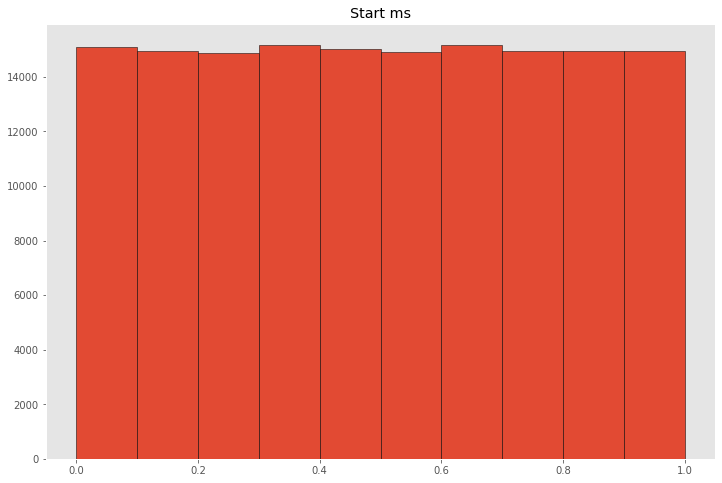

In [226]:
graphical_analysis(numeric_df,numerical_features,"univariate","hist",x=1)

array([[<AxesSubplot:title={'center':'End ms'}>]], dtype=object)

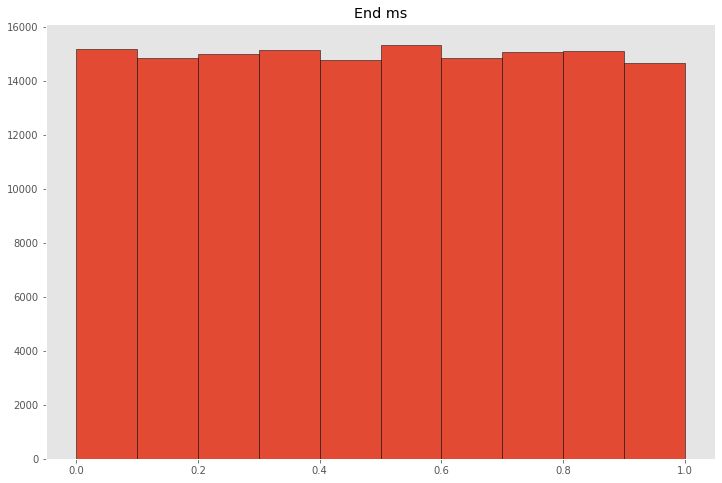

In [228]:
graphical_analysis(numeric_df,numerical_features,"univariate","hist",x=2)

array([[<AxesSubplot:title={'center':'Dur. (ms)'}>]], dtype=object)

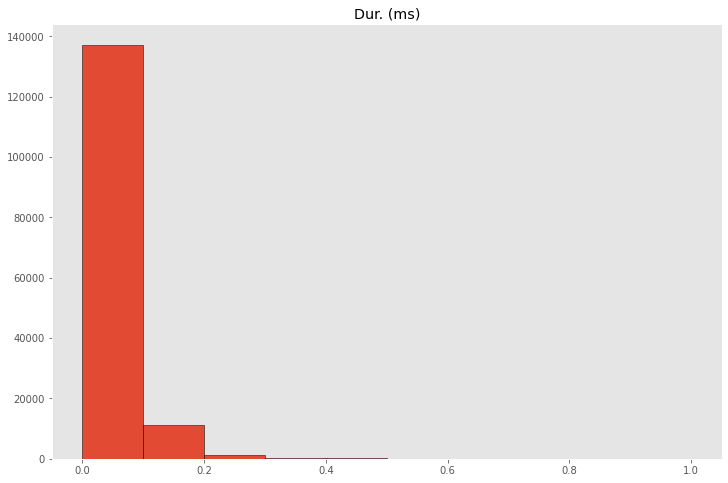

In [229]:
graphical_analysis(numeric_df,numerical_features,"univariate","hist",x=3)

<AxesSubplot:>

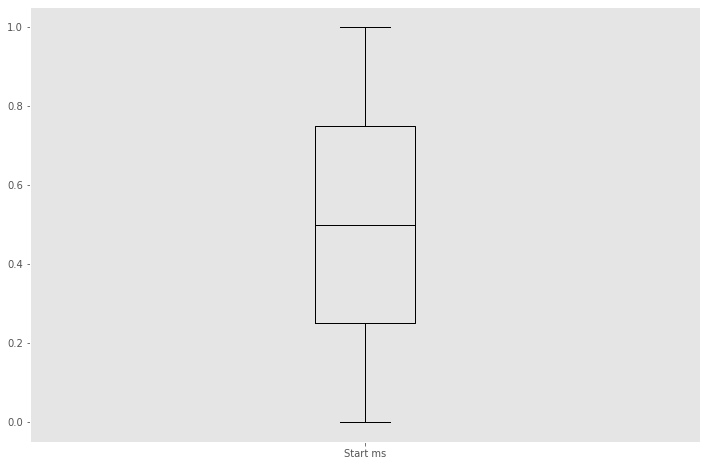

In [231]:
graphical_analysis(numeric_df,numerical_features,"univariate","box",1)

<AxesSubplot:>

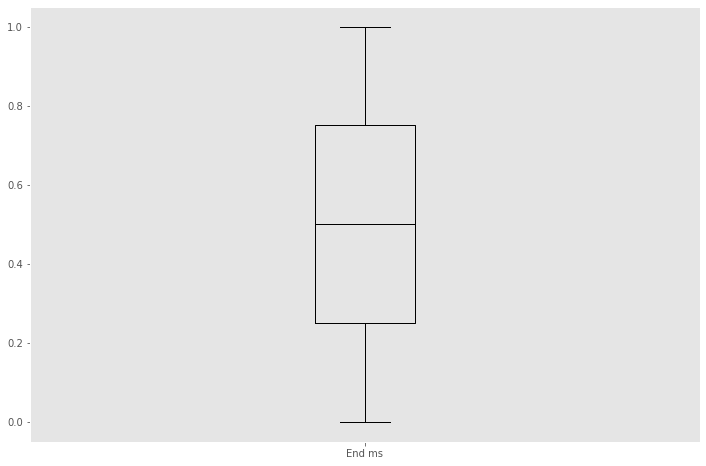

In [233]:
graphical_analysis(numeric_df,numerical_features,"univariate","box",x=2)

<AxesSubplot:>

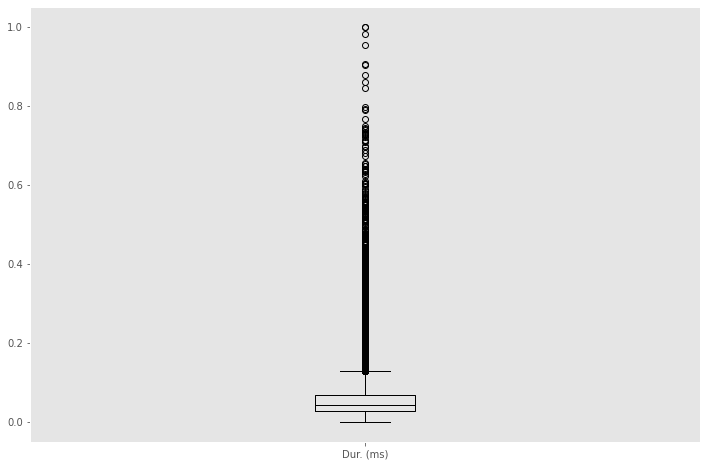

In [234]:
graphical_analysis(numeric_df,numerical_features,"univariate","box",x=3)

<AxesSubplot:>

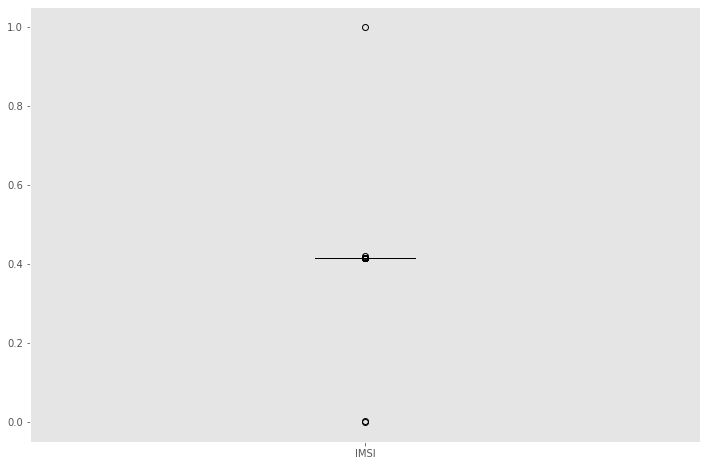

In [236]:
graphical_analysis(numeric_df,numerical_features,"univariate","box",x=4)

<AxesSubplot:xlabel='Start ms', ylabel='Density'>

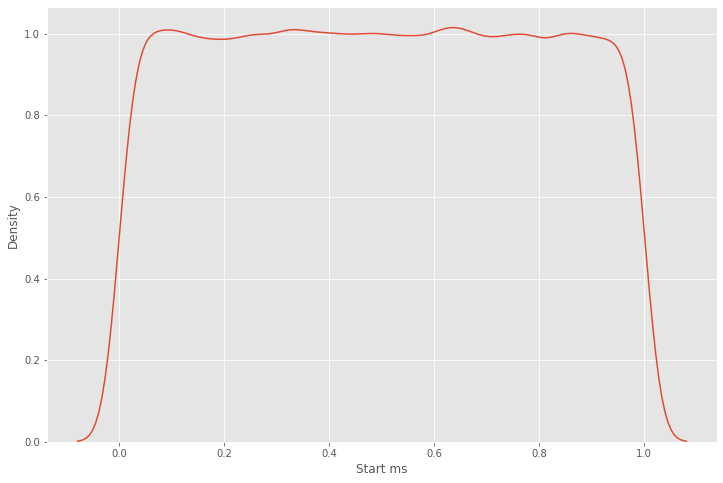

In [238]:
graphical_analysis(numeric_df,numerical_features,"univariate","curve",x=1)

<AxesSubplot:xlabel='End ms', ylabel='Density'>

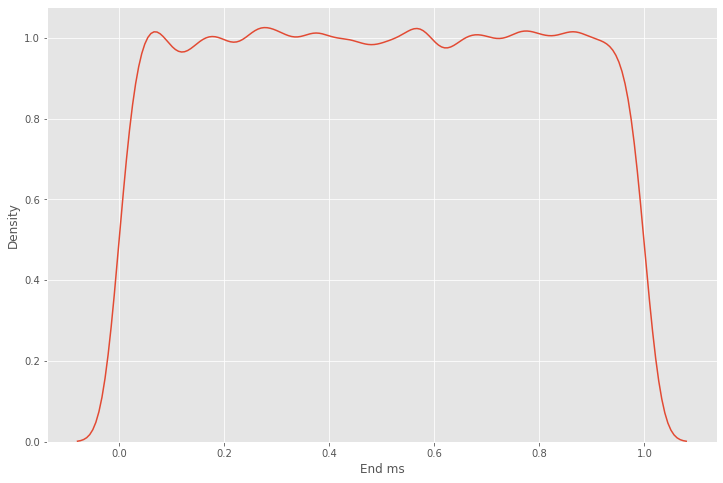

In [240]:
graphical_analysis(numeric_df,numerical_features,"univariate","curve",x=2)

<AxesSubplot:xlabel='Dur. (ms)', ylabel='Density'>

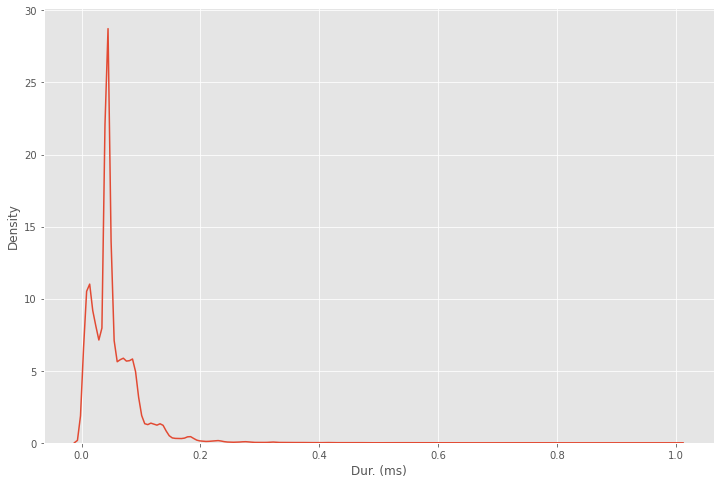

In [241]:
graphical_analysis(numeric_df,numerical_features,"univariate","curve",x=3)

<AxesSubplot:xlabel='IMSI', ylabel='Density'>

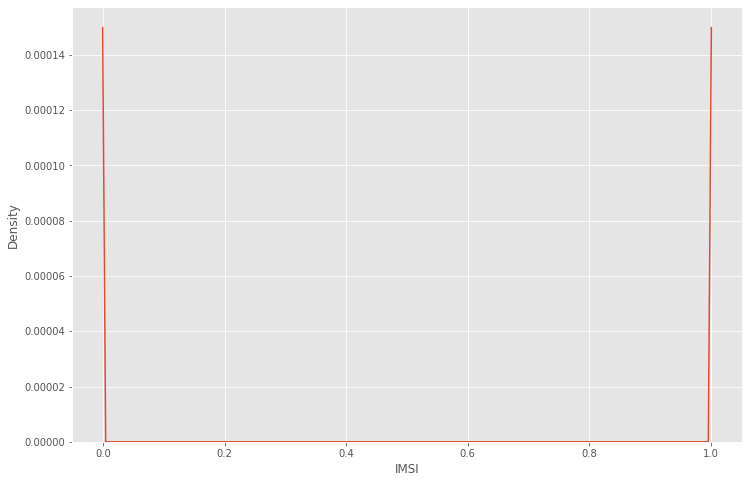

In [242]:
graphical_analysis(numeric_df,numerical_features,"univariate","curve",x=4)

In [246]:
# Bivariate Analysis – explore the relationship between each application & 
# the total DL+UL data using appropriate methods and interpret your findings. 
graphical_analysis(numeric_df,numerical_features,"bivariate","box",x=1,y=2)

TypeError: graphical_analysis() got an unexpected keyword argument 'y'

In [ ]:
X = numerical_transforms
y = numerical_transforms[]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.3, 
                                                random_state=1121218)

In [138]:
len(numerical_transforms[25:,])

149976

In [71]:
pca_1 = pd.concat([X_train,y_train])

In [72]:
pca_1.shape

(150000, 55)

In [63]:
X = X_train
y = y_train
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.5, 
                                                random_state=1121218)

In [64]:
#### pca analysis
pca_2 = pd.concat([X_valid,y_valid])

In [65]:
pca_2.shape

(105000, 55)

In [66]:
pca_3 = pd.concat([X_train,y_train])

In [67]:
pca_3.shape

(105000, 55)

In [74]:
all_samples = np.concatenate((pca_2, pca_3), axis=1)

In [75]:
mean_pca_1 = np.mean(pca_2)

In [77]:
mean_pca_2 = np.mean(pca_3)

In [78]:
mean_vector = np.array([[mean_pca_1],[mean_pca_2]])

In [79]:
mean_vector

array([[[4.54295952e+08, 7.79753474e-01, 1.71721947e+00, 3.08243220e+00,
         1.57524021e-01, 1.81004687e+06, 1.39066567e+06, 1.33287265e+04,
         1.76804914e+03, 1.08596152e+02, 1.76773952e+01, 9.28219105e+01,
         1.62339949e+00, 1.05063711e+05, 1.05064256e+08, 1.78390041e+06,
         4.66875666e+05, 4.98175241e+02, 4.21604939e+08, 8.26757629e+06,
         5.75133629e+06, 2.05923587e+06, 1.14690937e+08, 3.37541770e+06,
         4.83875038e+13, 2.08201762e+14, 3.36745482e+10, 9.86969119e+02,
         3.50048430e+02, 8.08374346e+02, 1.55054519e+02, 9.60546426e+02,
         1.49170983e+02, 3.64141976e+03, 3.93752416e+03, 1.16478738e+07,
         1.09848253e+07, 4.21085620e+08, 8.23492703e+06, 1.79633005e+06,
         3.28865301e+04, 5.00952647e+02, 1.99407532e+07, 6.90309549e+05,
         4.10422844e+07, 9.85199441e+01, 7.60440991e-02, 1.17115787e+07,
         1.09959592e+07]],

       [[4.55273197e+08, 7.70623396e-01, 1.72438474e+00, 3.08433804e+00,
         1.41978620e-01

In [89]:
scatter_matrix = np.zeros((2,2))

In [118]:
from sklearn.decomposition import PCA

In [140]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

In [145]:
round(len(df)*0.3)

45000

In [149]:
data_transforms = numeric_pipeline.fit_transform(df.select_dtypes(include='number'))

In [156]:
train = data_transforms[round(len(df)*0.7):]

In [157]:
test = data_transforms[round(len(df)*0.3):]

In [135]:
len(numerical_transforms)

150001

In [115]:
def pca_dec(data, n):
    pca = PCA(n)
    X_dec = pca.fit_transform(data)
    return X_dec, pca


In [158]:
pca_train_results, pca_train = pca_dec(train, 10)

In [159]:
pca_test_results, pca_test = pca_dec(test, 10)

In [164]:
#Creating a table with the explained variance ratio
names_pcas = [f"PCA Component {i}" for i in range(1, 11, 1)]
scree = pd.DataFrame(list(zip(names_pcas, pca_train.explained_variance_ratio_)), columns=["Component", "Explained Variance Ratio"])
print(scree)

          Component  Explained Variance Ratio
0   PCA Component 1                  0.102829
1   PCA Component 2                  0.068152
2   PCA Component 3                  0.063804
3   PCA Component 4                  0.056242
4   PCA Component 5                  0.055653
5   PCA Component 6                  0.055301
6   PCA Component 7                  0.055061
7   PCA Component 8                  0.054711
8   PCA Component 9                  0.054359
9  PCA Component 10                  0.054217


In [169]:
len(pca_train.components_[0])

49

In [174]:
#Sorting the values of the first principal component by how large each one is
df = pd.DataFrame({'PCA':pca_train.components_[0], 'Variable Names':numerical_features})
df = df.sort_values('PCA', ascending=False)

#Sorting the absolute values of the first principal component by magnitude
df2 = pd.DataFrame(df)
df2['PCA']=df2['PCA'].apply(np.absolute)
df2 = df2.sort_values('PCA', ascending=False)
#print(df2['Variable Names'][0:11])

df.head()

,PCA,Variable Names
0,0.016429,Start ms
1,0.016254,End ms
45,0.006213,Other DL (Bytes)
37,0.006036,Email DL (Bytes)
35,0.003318,Google DL (Bytes)


In [178]:
#Sorting the values of the first principal component by how large each one is
for i in range(len(pca_train.components_)):
    df = pd.DataFrame({'PCA':pca_train.components_[i], 'Variable Names':numerical_features})
    df = df.sort_values('PCA', ascending=False)

    #Sorting the absolute values of the first principal component by magnitude
    df2 = pd.DataFrame(df)
    df2['PCA']=df2['PCA'].apply(np.absolute)
    df2 = df2.sort_values('PCA', ascending=False)
    #print(df2['Variable Names'][0:11])

    print(df.head())

         PCA     Variable Names
0   0.016429           Start ms
1   0.016254             End ms
45  0.006213   Other DL (Bytes)
37  0.006036   Email DL (Bytes)
35  0.003318  Google DL (Bytes)
         PCA      Variable Names
0   0.067258            Start ms
1   0.066972              End ms
35  0.027149   Google DL (Bytes)
41  0.026389  Netflix DL (Bytes)
45  0.023379    Other DL (Bytes)
         PCA           Variable Names
34  0.037392  Social Media UL (Bytes)
38  0.031206         Email UL (Bytes)
37  0.024136         Email DL (Bytes)
39  0.009145       Youtube DL (Bytes)
33  0.009004  Social Media DL (Bytes)
         PCA           Variable Names
33  0.464824  Social Media DL (Bytes)
46  0.434040         Other UL (Bytes)
37  0.433075         Email DL (Bytes)
38  0.209987         Email UL (Bytes)
45  0.087597         Other DL (Bytes)
         PCA           Variable Names
34  0.504424  Social Media UL (Bytes)
44  0.238012        Gaming UL (Bytes)
38  0.209118         Email UL (Bytes)
42

In [184]:
numerical_features

['Start ms',
 'End ms',
 'Dur. (ms)',
 'IMSI',
 'MSISDN/Number',
 'IMEI',
 'Avg RTT DL (ms)',
 'Avg RTT UL (ms)',
 'Avg Bearer TP DL (kbps)',
 'Avg Bearer TP UL (kbps)',
 'TCP DL Retrans. Vol (Bytes)',
 'TCP UL Retrans. Vol (Bytes)',
 'DL TP < 50 Kbps (%)',
 '50 Kbps < DL TP < 250 Kbps (%)',
 '250 Kbps < DL TP < 1 Mbps (%)',
 'DL TP > 1 Mbps (%)',
 'UL TP < 10 Kbps (%)',
 '10 Kbps < UL TP < 50 Kbps (%)',
 '50 Kbps < UL TP < 300 Kbps (%)',
 'UL TP > 300 Kbps (%)',
 'HTTP DL (Bytes)',
 'HTTP UL (Bytes)',
 'Activity Duration DL (ms)',
 'Activity Duration UL (ms)',
 'Dur. (ms).1',
 'Nb of sec with 125000B < Vol DL',
 'Nb of sec with 1250B < Vol UL < 6250B',
 'Nb of sec with 31250B < Vol DL < 125000B',
 'Nb of sec with 37500B < Vol UL',
 'Nb of sec with 6250B < Vol DL < 31250B',
 'Nb of sec with 6250B < Vol UL < 37500B',
 'Nb of sec with Vol DL < 6250B',
 'Nb of sec with Vol UL < 1250B',
 'Social Media DL (Bytes)',
 'Social Media UL (Bytes)',
 'Google DL (Bytes)',
 'Google UL (Bytes)',
 'Em

In [185]:
categorical_features

['Bearer Id',
 'Start',
 'End',
 'Last Location Name',
 'Handset Manufacturer',
 'Handset Type']

In [191]:
#bivariate analysis
import seaborn as sns
pd.crosstab(X_valid['Start'], X_valid['End'], margins=True, values=X_valid['Google DL (Bytes)'], aggfunc=pd.Series.count)
# 3 any other aggregation function can be used based on column type
# to create a heatmap by enclosing the above in sns.heatmap
# sns.heatmap(pd.crosstab(df['Start'], df['End'], margins=True, values=df['Total DL (Bytes)'], aggfunc=pd.Series.count),
#             cmap="YlGnBu", annot=True, cbar=False)

MemoryError: Unable to allocate 11.7 GiB for an array with shape (40615, 38589) and data type float64

In [14]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [15]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311450e+19,4/4/19 12:01,770.0,4/25/19 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16457E+15,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311450e+19,4/9/19 13:04,235.0,4/25/19 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311450e+19,4/9/19 17:42,1.0,4/25/19 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311450e+19,4/10/19 0:31,486.0,4/25/19 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311450e+19,4/12/19 20:10,565.0,4/25/19 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [20]:
# categorizing data
categorizing_deciles = pd.qcut(df['Dur. (ms)'], 10,duplicates='drop')

In [39]:
deciles = categorizing_deciles.values.codes
deciles

array([ 8,  8,  8, ...,  5,  5, -1], dtype=int8)

In [40]:
df['Dur. (ms)'][8]

941634.0

In [42]:
categorizing_deciles.values[5]

Interval(181415.1, 1859336.0, closed='right')

In [11]:
### correlation matrix

In [9]:
applications = df[['Social Media DL (Bytes)', 'Social Media UL (Bytes)',
       'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)',
       'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
       'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)',
       'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)']]

In [12]:
social_media_corelation_matrix  = applications.corr()

In [13]:
social_media_corelation_matrix

,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes)
Social Media DL (Bytes),1.000000,-0.000555,-0.001954,0.000186,0.004745,-0.002518,-0.001389,0.002345,-0.001817,0.003457,0.001018,0.003095,0.006126,0.000610
Social Media UL (Bytes),-0.000555,1.000000,0.003542,0.001085,0.004823,-0.001427,-0.001786,-0.002368,-0.000772,-0.002493,0.000210,0.000844,-0.003850,0.000971
Google DL (Bytes),-0.001954,0.003542,1.000000,-0.000103,-0.000039,0.000742,0.001760,0.000638,0.000548,-0.001569,-0.001421,-0.001429,-0.002557,-0.000882
Google UL (Bytes),0.000186,0.001085,-0.000103,1.000000,-0.001157,-0.002050,0.001122,0.001670,-0.001288,-0.004073,0.001140,-0.002516,0.002097,-0.002219
Email DL (Bytes),0.004745,0.004823,-0.000039,-0.001157,1.000000,0.002553,0.001679,-0.004305,0.001351,-0.000016,0.000050,-0.004335,-0.000444,0.004675
Email UL (Bytes),-0.002518,-0.001427,0.000742,-0.002050,0.002553,1.000000,-0.000320,-0.006834,-0.000011,0.000532,-0.002519,0.005000,-0.003805,0.000081
Youtube DL (Bytes),-0.001389,-0.001786,0.001760,0.001122,0.001679,-0.000320,1.000000,0.002433,0.001202,0.001746,-0.001861,-0.001893,0.002042,-0.004830
Youtube UL (Bytes),0.002345,-0.002368,0.000638,0.001670,-0.004305,-0.006834,0.002433,1.000000,0.000423,0.002477,-0.002382,0.000898,0.002296,-0.001393
Netflix DL (Bytes),-0.001817,-0.000772,0.000548,-0.001288,0.001351,-0.000011,0.001202,0.000423,1.000000,0.001065,-0.003201,-0.000633,-0.006000,-0.002588
Netflix UL (Bytes),0.003457,-0.002493,-0.001569,-0.004073,-0.000016,0.000532,0.001746,0.002477,0.001065,1.000000,-0.001051,-0.004015,-0.006691,-0.003447


array([[<AxesSubplot:title={'center':'Start ms'}>,
        <AxesSubplot:title={'center':'End ms'}>,
        <AxesSubplot:title={'center':'Dur. (ms)'}>,
        <AxesSubplot:title={'center':'IMSI'}>,
        <AxesSubplot:title={'center':'MSISDN/Number'}>,
        <AxesSubplot:title={'center':'IMEI'}>,
        <AxesSubplot:title={'center':'Avg RTT DL (ms)'}>],
       [<AxesSubplot:title={'center':'Avg RTT UL (ms)'}>,
        <AxesSubplot:title={'center':'Avg Bearer TP DL (kbps)'}>,
        <AxesSubplot:title={'center':'Avg Bearer TP UL (kbps)'}>,
        <AxesSubplot:title={'center':'TCP DL Retrans. Vol (Bytes)'}>,
        <AxesSubplot:title={'center':'TCP UL Retrans. Vol (Bytes)'}>,
        <AxesSubplot:title={'center':'DL TP < 50 Kbps (%)'}>,
        <AxesSubplot:title={'center':'50 Kbps < DL TP < 250 Kbps (%)'}>],
       [<AxesSubplot:title={'center':'250 Kbps < DL TP < 1 Mbps (%)'}>,
        <AxesSubplot:title={'center':'DL TP > 1 Mbps (%)'}>,
        <AxesSubplot:title={'center':'UL

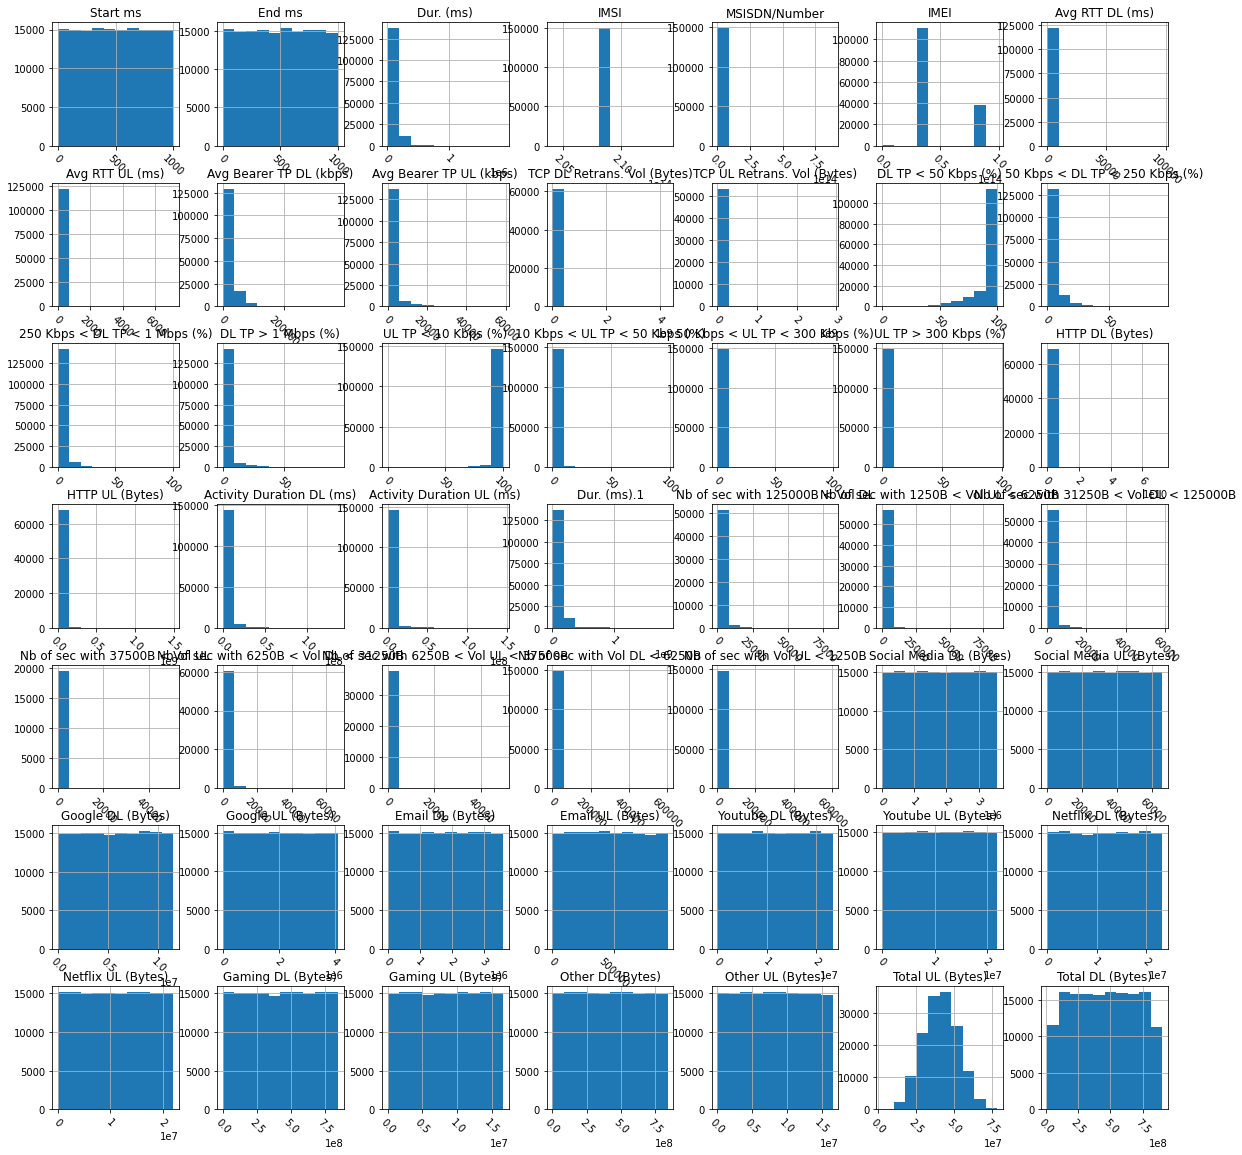

In [113]:
df.hist(figsize=(20,20), xrot=-45)

In [ ]:
report = ProfileReport(report_df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [179]:
df.head(4)

,PCA,Variable Names
34,0.423822,Social Media UL (Bytes)
33,0.271336,Social Media DL (Bytes)
35,0.238501,Google DL (Bytes)
45,0.203970,Other DL (Bytes)


In [ ]:
report.to_file("report.html")

In [8]:
## scaling and normalizing of the dataset

In [3]:
numerical_features = df.select_dtypes(include='number').columns.tolist()

In [4]:
categorical_features = df.select_dtypes(exclude='number').columns.to_list()

In [5]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [6]:
preprocessed_data = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

In [7]:
numerical_transforms = numeric_pipeline.fit_transform(df.select_dtypes(include='number'))

In [10]:
numerical_features

['Bearer Id',
 'Start ms',
 'End ms',
 'Dur. (ms)',
 'IMSI',
 'MSISDN/Number',
 'IMEI',
 'Avg RTT DL (ms)',
 'Avg RTT UL (ms)',
 'Avg Bearer TP DL (kbps)',
 'Avg Bearer TP UL (kbps)',
 'TCP DL Retrans. Vol (Bytes)',
 'TCP UL Retrans. Vol (Bytes)',
 'DL TP < 50 Kbps (%)',
 '50 Kbps < DL TP < 250 Kbps (%)',
 '250 Kbps < DL TP < 1 Mbps (%)',
 'DL TP > 1 Mbps (%)',
 'UL TP < 10 Kbps (%)',
 '10 Kbps < UL TP < 50 Kbps (%)',
 '50 Kbps < UL TP < 300 Kbps (%)',
 'UL TP > 300 Kbps (%)',
 'HTTP DL (Bytes)',
 'HTTP UL (Bytes)',
 'Activity Duration DL (ms)',
 'Activity Duration UL (ms)',
 'Dur. (ms).1',
 'Nb of sec with 125000B < Vol DL',
 'Nb of sec with 1250B < Vol UL < 6250B',
 'Nb of sec with 31250B < Vol DL < 125000B',
 'Nb of sec with 37500B < Vol UL',
 'Nb of sec with 6250B < Vol DL < 31250B',
 'Nb of sec with 6250B < Vol UL < 37500B',
 'Nb of sec with Vol DL < 6250B',
 'Nb of sec with Vol UL < 1250B',
 'Social Media DL (Bytes)',
 'Social Media UL (Bytes)',
 'Google DL (Bytes)',
 'Google UL 

In [19]:
test_df = pd.DataFrame(numerical_transforms[1:10],columns=numerical_features)

In [ ]:
report = ProfileReport(test_df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [199]:
categorical_features

['Bearer Id',
 'Start',
 'End',
 'Last Location Name',
 'Handset Manufacturer',
 'Handset Type']

In [217]:
df.select_dtypes(include=['object']).astype(str)

,Bearer Id,Last Location Name,Handset Manufacturer,Handset Type
0,13114483460844900352,9164566995485190,Samsung,Samsung Galaxy A5 Sm-A520F
1,13114483482878900224,L77566A,Samsung,Samsung Galaxy J5 (Sm-J530)
2,13114483484080500736,D42335A,Samsung,Samsung Galaxy A8 (2018)
3,13114483485442799616,T21824A,undefined,undefined
4,13114483499480700928,D88865A,Samsung,Samsung Sm-G390F
...,...,...,...,...
149996,7277825670196679680,D20434A,Apple,Apple iPhone 8 Plus (A1897)
149997,7349883264234609664,D10223C,Apple,Apple iPhone Se (A1723)
149998,13114483573367300096,T51102A,Apple,Apple iPhone Xs (A2097)
149999,13114483573367300096,L88342B,Huawei,Huawei Fig-Lx1


In [54]:
## measures of dispersion
pd.DataFrame(numerical_transforms).describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,150001.000000,150001.000000,150001.000000,150001.000000,150001.000000,1.500010e+05,150001.000000,150001.000000,150001.000000,150001.000000,...,150001.000000,150001.000000,150001.000000,150001.000000,150001.000000,150001.000000,150001.000000,150001.000000,150001.000000,150001.000000
mean,0.513854,0.499688,0.499300,0.052622,0.414326,9.385948e-06,0.487357,0.001133,0.002481,0.035170,...,0.500193,0.500153,0.499881,0.499807,0.500382,0.500542,0.499262,0.499113,0.506919,0.499555
std,0.459980,0.288900,0.288385,0.043752,0.002139,2.763862e-03,0.227002,0.005771,0.010749,0.063391,...,0.288514,0.288273,0.289143,0.288911,0.289253,0.288832,0.288349,0.288006,0.149426,0.272524
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.068965,0.250250,0.251251,0.027157,0.414303,5.724065e-08,0.355339,0.000361,0.000421,0.000114,...,0.250803,0.250677,0.248380,0.248772,0.249539,0.249320,0.249198,0.250370,0.402244,0.263428
50%,0.068965,0.499499,0.500501,0.042791,0.414317,7.116771e-08,0.357975,0.000557,0.000983,0.000167,...,0.499417,0.500337,0.500542,0.499563,0.501999,0.500711,0.500095,0.499250,0.507211,0.500892
75%,0.977014,0.749750,0.750751,0.067643,0.414340,9.489199e-08,0.869305,0.001133,0.002481,0.052121,...,0.750180,0.750298,0.751121,0.749922,0.750702,0.750756,0.748944,0.747886,0.611776,0.735153
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
numerical_transforms

array([[0.98850572, 0.77077077, 0.66266266, ..., 0.53230399, 0.44899105,
        0.33684625],
       [0.98850572, 0.23523524, 0.60660661, ..., 0.90919131, 0.67493396,
        0.72140079],
       [0.98850572, 0.001001  , 0.65265265, ..., 0.2545866 , 0.33150386,
        0.30439426],
       ...,
       [0.98850573, 0.28328328, 0.81081081, ..., 0.68330261, 0.4246416 ,
        0.65375757],
       [0.98850573, 0.6966967 , 0.32732733, ..., 0.08495744, 0.35459365,
        0.40718827],
       [0.51385153, 0.49968789, 0.49930018, ..., 0.4991133 , 0.50691856,
        0.49955529]])

In [57]:
numerical_features

['Bearer Id',
 'Start ms',
 'End ms',
 'Dur. (ms)',
 'IMSI',
 'MSISDN/Number',
 'IMEI',
 'Avg RTT DL (ms)',
 'Avg RTT UL (ms)',
 'Avg Bearer TP DL (kbps)',
 'Avg Bearer TP UL (kbps)',
 'TCP DL Retrans. Vol (Bytes)',
 'TCP UL Retrans. Vol (Bytes)',
 'DL TP < 50 Kbps (%)',
 '50 Kbps < DL TP < 250 Kbps (%)',
 '250 Kbps < DL TP < 1 Mbps (%)',
 'DL TP > 1 Mbps (%)',
 'UL TP < 10 Kbps (%)',
 '10 Kbps < UL TP < 50 Kbps (%)',
 '50 Kbps < UL TP < 300 Kbps (%)',
 'UL TP > 300 Kbps (%)',
 'HTTP DL (Bytes)',
 'HTTP UL (Bytes)',
 'Activity Duration DL (ms)',
 'Activity Duration UL (ms)',
 'Dur. (ms).1',
 'Nb of sec with 125000B < Vol DL',
 'Nb of sec with 1250B < Vol UL < 6250B',
 'Nb of sec with 31250B < Vol DL < 125000B',
 'Nb of sec with 37500B < Vol UL',
 'Nb of sec with 6250B < Vol DL < 31250B',
 'Nb of sec with 6250B < Vol UL < 37500B',
 'Nb of sec with Vol DL < 6250B',
 'Nb of sec with Vol UL < 1250B',
 'Social Media DL (Bytes)',
 'Social Media UL (Bytes)',
 'Google DL (Bytes)',
 'Google UL 

In [62]:
len(numerical_transforms[1:])

150000

In [ ]:
## univariate analysis
sns.distplot(numerical_transforms[1:], bins=50, kde=True, rug=True)